# Predicting Sentiments about Brands and Products on Twitter

We four intrepid data scientists, as a project for our data science intensive bootcamp through Flatiron school, set out to create a model that could determine how people feel about products or brands through their tweets.  Twitter is gold mine of emotional sentiment, as users impulsively express themselves in short, terse terms.  Tweets about given products are easy to collect as users use hashtags to communicate the topics of their expression.

We created a model when given a tweet or series of tweets and a product would determine how the user felt about that product.  This is trivial for a human to accomplish, but our model can do this for thousands or even millions of tweets in a small amount of time.  

This is not a trival problem.  Twitterspeak is rife with spelling errors, shortened words, acronyms, hashtags, and very specific words and proper nouns.  These are hard or impossible for a model to learn and are even confusing for humans much of the time.  Emotions are also complicated and a tweet may have a mix of emotions, ambiguous emotions, or conditional emotions.  The spectrum of feeling is much greater than our categories of positive, negative, or neutral.

Emotions are also relative.  Consier the phrase, "iPhones are better than Android phones."  Is this a positive or a negative tweet?  It depends!  This is why we chose to give our model a clue to which product we want the emotions to be classified in reference to.  We used the product name supplied in the 'product' column of our table to replace instances of that product in the tweet test with 'targetproduct'.  This helped our model to contextualize emotions and deal with this relativity.  

A model only learns as well as it's labels, and our data was labeled by humans.  Each human may have a different interpretation of a tweet.  The data was most likely labeled by different humans, and so there may be different opinions about the emotional context of a tweet expressed by different human labelers.

These considerations make this problem particularly sticky, and we are proud of the success that our models had in decifering the tweets.  As is often true with NLP problems, the structure of the model is often less important than how the data is prepared.

We tried many different approaches to this problem, from recurrent neural networks to convolutional neural networks, to a simple logistic regression model.  Each used model approached the problem in a different way, but they all were able to classify over 3/5ths of tweets correctly, giving a client a general sense, over a large sampling of tweets, what the sentiment is about their product in the twitterverse.

Load dependencies

In [3]:
import pandas as pd
import numpy as np

import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, \
Input, Dense, LSTM, Embedding, Flatten

from keras.layers.convolutional import Conv1D, MaxPooling1D

from keras.models import Sequential
from keras import initializers, regularizers, optimizers, layers
from keras.preprocessing import text, sequence
from keras.utils import plot_model
import kerastuner as kt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from gensim.models import word2vec

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import sys
sys.path.append("../")

import src.model_evaluation as me
from src.data_preprocessing import *

sns.set(context = 'notebook', style = 'whitegrid')
# CHANGE LATER
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

np.random.seed(42)
tf.random.set_seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\awyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\awyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\awyeh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Exploration

In [43]:
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
df.columns = ['text', 'target', 'emotion']
df['emotion'] = df['emotion'].replace(to_replace = {'Positive emotion' : 2, 'Negative emotion' : 0, 'No emotion toward brand or product': 1})
df = df[df['emotion'] != 'I can\'t tell']

In [47]:
df.head()

,text,target,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,2
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,2
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,2


Luckily our dataset is simple to work with.  It has three columns, with every row being a new tweet.  The first column is the text column, which contains all the words in the tweet.  The second column is the target column, which contains the product the tweet is targeted at.  The last column is the emotion column, and this contains the feeling the tweet has towards it's respective target.  The emotion column is our target for our predictive models, and can have three possible values: 0, 1, or 2, or negative, no neutral, and positive respectively.

To start off, we must check the class imbalance of our targets.

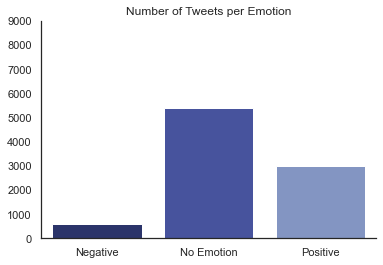

In [44]:
# emotion breakdown by target but fancier
sns.set(context = 'notebook', style = 'white', font_scale = 1)

blue_ppt = ['#212d74', '#3949ab', '#7890cd']
red_ppt = ['#9c254d', '#d23369', '#f06292']

x1 = df['emotion'].value_counts().keys()
y1 = df['emotion'].value_counts().values
xlabel = ''
ylabel = ''
xticks = ['Negative', 'No Emotion', 'Positive']
yticks = ''
order = [0,1,2]

ax = sns.barplot(x = x1, y = y1, alpha = 1, order = order, palette = blue_ppt)
ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, title = 'Number of Tweets per Emotion')
ax.set_ylim(0,9000)
sns.despine()

As seen above, we have incredibly heavy class imbalance; not only is 'positive' almost just half of 'no emotion', the amount of 'negative' values we have is barely visible.  To deal with this imbalance, we chose to import extra data to make up for it.  The data we need must meet two requirements, which is that it must have a new tweet for each row, have a column dedicated to the tweet text, and lastly have a column dedicated to the tweet emotion.  We found three datasets that meet this requirement, a dataset relating to apple product, a dataset describing tweets about the Deflategate NFL incident, and lastly a dataset containing tweets about the 2015 Coachella.  We took these three datasets, restructured them so that they fit our base data, and then added it to it.

In [45]:
dv = pd.read_csv('../data/targeted_combined.csv')
dv['emotion'] = dv['emotion'].astype(int)

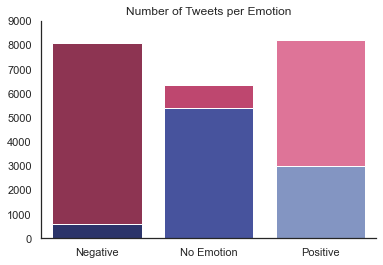

In [46]:
sns.set(context = 'notebook', style = 'white', font_scale = 1)

blue_ppt = ['#212d74', '#3949ab', '#7890cd']
red_ppt = ['#9c254d', '#d23369', '#f06292']

x2 = dv['emotion'].value_counts().keys()
y2 = dv['emotion'].value_counts().values
xlabel = ''
ylabel = ''
xticks = ['Negative', 'No Emotion', 'Positive']
yticks = ''

ax = sns.barplot(x = x2, y = y2, alpha = 1, palette = red_ppt)
ax = sns.barplot(x = x1, y = y1, alpha = 1, palette = blue_ppt)


ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, title = 'Number of Tweets per Emotion')
ax.set_ylim(0,9000)
sns.despine()
# plt.savefig('tweets_per_emotion_after', dpi = 500, bbox_inches = 'tight', transparent = True)

The red portions in the above plot symbolize the new data after we imported the extra data.  The disparity between the different emotional targets have now become much more close.  Now both 'positives' and 'negatives' are at a near equal amount, with 'no emotion' being closely behind.

# Data Preparation and Preprocessing

Now that we have our data, our next step is to preproces our data into a format ready for consumption by our predictive models.  As we understand that models work best on clean words with no punctuation, stopwords, word endings, capitalization, etc. we created functions for cleaning every tweet in our dataset.

While we are cleaning the data, we also decided to undergo another bit of feature engineering.  As we want our model to predict the sentiment on a wide variety of products not just the ones in our base dataset, we decided to make every product that we can find as anonymous as possible.  This is done by filtering the tweet text of their respective target and changing them into one universal term, 'product_target'.  For example, a tweet proclaiming that "I love my iPhone!" will become "I love my product_target!"  By doing this, our model will be more focused on the context of the tweet rather than basing predictions off of pre-existing sentiments users have towards a product.  It will be more focused on the "I love me" portion of the sentence rather than automatically being biased that the tweet is positive since most tweets discussing iPhones in our data ended up being positive.

In [4]:
def get_wordnet_pos(treebank_tag):
    '''
    Function takes in a string and assigns it a part of speech tag.
    Used for lemmatizing, no need to use elsewhere
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def product_target(string):
    '''
    Description:
    - Method used for finding a string that the clean function will replace with 'product_target' if it sees any instances of it.
    
    Inputs:
    - Takes in the data from the product column through the string parameter.
    
    Steps:
    1. sets the target variable to lower case
    2. searches what the variable is and return a preset value that we will replace with 'product_target'
    
    Outputs:
    - Returns a string
    '''
    s = string.lower()
    if s == 'no target':
        return ''
    elif s == 'ipad':
        return 'ipad'
    elif s == 'apple':
        return 'apple'
    elif s == 'ipad or iphone app':
        return 'app'
    elif s == 'iphone':
        return 'iphone'
    elif s == 'other apple product or service':
        return ''
    elif s == 'google':
        return 'google'
    elif s == 'other google product or service':
        return ''
    elif s == 'android':
        return 'android'
    elif s == 'android app':
        return 'android'
    else:
        return 'Unknown target'

def txt_clean(txt, lem):
    '''
    Description
    - A method we use to clean every inputed string and prepare it for model processing
    
    Inputs:
    - Takes in a string and returns a cleaned up version of it.
    - Takes in a  boolean variable to determine whether or not the lemmatizing function will be used.
    
    Steps:
    1. Split the tweet into tokens
    2. Convert all capitalized letters into lower-case
    3. Remove punctuation
    4. Remove twitter jargon such as @ mentions
    5. Remove leftover numbers
    6. Remove words with accents
    7. Remove stop words
    8. Replace instances of the target in the text with 'product_target'
    9. Remove empty strings
    10. Lemmatize the words
    11. Rejoin all the tokens into one string
    
    Outputs:
    - A cleaned up string of words ready for model processing.
    '''
    sw = stopwords.words('english')
    sw.extend(['link', 'rt', 'get'])
    punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#'
    no_accents_re = re.compile('^[a-z]+$')
    accents = ['á', 'â', 'ã', 'à', 'å', 'ª', 'ç', 'è', '¼', '¾', 'î', 'ï', 'ì', 'ó', 'ö', 'ð', 'ü', 'ù', 'û', 'ý']
    twitter_re = re.compile('[@][a-zA-Z]*')
    num_re = re.compile('^\d+$')
    
    # splitting the text up into words
    if isinstance(txt, list):
        t = txt[0].split(' ')
    else:
        t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing words with accents
    t = [w for w in t if no_accents_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in sw]
    # change targets in string to 'product_target' if a target exists
    if isinstance(txt, list):
        t = ['product_target' if w in product_target(txt[1]) else w for w in t]
        if txt[1].lower() in ['android app', 'ipad or iphone app']:
            t = [w for w in t if w is not 'app']
    # removing empty strings
    t = [w for w in t if w]
    # word lemmatizing
    if lem: 
        lemm = WordNetLemmatizer()
        t = pos_tag(t)
        t = [(w[0], get_wordnet_pos(w[1])) for w in t]
        t = [lemm.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)

def emotion_label(string):
    '''
    Description:
    - Simple mapping function used to turn our targets from words into a numerical value
    
    Inputs:
    - A string
    
    Steps:
    1. Matches the input string with a preset value, positive is a 2, negative is a 0, and neutral is a 1
    
    Output:
    - The corresponding integer value
    '''
    s = string
    if s == 'Positive emotion':
        return 2
    elif s == 'No emotion toward brand or product':
        return 1
    elif s == 'Negative emotion':
        return 0
    else:
        print('Unknown emotion')

def df_clean(df = None, lem = True):
    '''
    Description:
    - A function that returns a cleaned up dataframe.
    
    Inputs:
    - It can take a dataframe, if no dataframe is passed through it will use our default one.
    - It can also set a boolean value, it is used as a flag to determine if lemmatizing will be used.
    
    Steps:
    1. A dataframe will be either created or brought in from an external source determined by the parameter
    2. The dataframe will then be adjusted to make reading easier
    3. NaN values and values we don't want will be removed
    4. We will use the emotion_label to change our emotion values into numerical
    5. We will use the txt_clean function on the tweet text for every row 
    6. Lastly we will drop unused columns
    
    Outputs:
    - A cleaned dataframe that we will use for our models
    '''
    if df is None:
        df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
    df.columns = ['text', 'product', 'emotion']
    df = df[df['emotion'] != 'I can\'t tell']
    df.dropna(inplace = True)
    df['text_product'] = df.apply(lambda x: list([x['text'], x['product']]), axis = 1)
    df['emotion'] = df['emotion'].map(emotion_label)
    df['txt_cleaned'] = df['text_product'].apply(txt_clean, args = (lem,))
    df.drop(columns = ['text', 'product', 'text_product'], inplace = True)
    return df


def external_data(lem = True):
    '''
    Description:
    - A function that gives us the cleaned up dataframes of our three external datasets
    - It will be cleaned in a way similar to our base dataset
    
    Inputs:
    - A boolean variable that will determine whether or not a lemmatizer is used or not
    
    Steps:
    1. Reads in the data from our datasets to create three dfs
    2. For each df, grab the columns that we care about and rename them to match our base data
    3. We then map our emotions column in a way that matches our base data (0, 1, and 2 variables)
    4. Use our txt_clean function to clean up the texts in the dataset
    5. Drop all unused columns
    6. Concat all three together
    
    Outputs:
    - A big dataframe containing cleaned up version of all the tweets from external sources
    - Ready to be added directly to the end of our base data
    '''

    df_1 = pd.read_csv('../data/Apple-Twitter-Sentiment-DFE.csv', encoding = 'latin1')
    df_1 = df_1[['sentiment', 'text']]
    df_1.columns = ['emotion', 'text']
    dic_1 = {'5': 2, '3' : 1, '1': 0}
    df_1.replace({'emotion': dic_1}, inplace = True)
    df_1['txt_cleaned'] = df_1['text'].apply(txt_clean, args = (lem,))
    df_1.drop('text', axis = 1, inplace = True)

    df_2 = pd.read_csv('../data/Deflategate-DFE.csv', encoding = 'latin1')
    df_2 = df_2[['deflate_sentiment', 'text']]
    df_2.columns = ['emotion', 'text']
    dic_2 = {'positive': 2, 'slightly positive': 2, ('neutral') : 1, 'negative': 0, 'slightly negative': 0}
    df_2.replace({'emotion': dic_2}, inplace = True)
    df_2['txt_cleaned'] = df_2['text'].apply(txt_clean, args = (lem,))
    df_2.drop('text', axis = 1, inplace = True)

    df_3 = pd.read_csv('../data/Coachella-2015-2-DFE.csv', encoding = 'latin1')
    df_3 = df_3[['coachella_sentiment', 'text']]
    df_3.columns = ['emotion', 'text']
    df_3 = df_3[df_3['emotion'] != 'cant tell']
    dic_3 = {'positive': 2, 'neutral' : 1, 'negative': 0}
    df_3.replace({'emotion': dic_3}, inplace = True)
    df_3['txt_cleaned'] = df_3['text'].apply(txt_clean, args = (lem,))
    df_3.drop('text', axis = 1, inplace = True)

    return pd.concat([df_1, df_2, df_3])

Here we use our functions df_clean() and external_data() to create cleaned up datasets ready for use, then we combine them into one using the concat function.

In [5]:
df_b = df_clean()
df_e = external_data()

df = pd.concat([df_b, df_e])

In [8]:
df.head()

,emotion,txt_cleaned
0,0,product_target hr tweet riseaustin dead need u...
1,2,know awesome ipadiphone product_target youll l...
2,2,wait product_target also sale sxsw
3,0,hope year festival isnt crashy year iphone pro...
4,2,great stuff fri sxsw marissa mayer product_tar...


In [7]:
df.shape

(22746, 2)

Now we are ready for modeling!

In [75]:
df.dropna(inplace = True)

X = df['txt_cleaned']
y = df['emotion']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)

### Preparing the data for the neural networks
A computer model does not do well analyzing actual text, but researchers have developed wonderful ways to turn words into numbers without losing too much of their meaning.  The below code tokenizes each tweet into numeric form ands the resulting sequences to ensure they are all the same length.  They are then fed into the embedding layer of the of both neural networks, which then embeds them into semantically meaningful high dimensional space for the next layers to use to decode and understand the tweets.  

In [60]:

embedding_size = 64
sequence_len = 128
tokenizer = text.Tokenizer()

#tokenize full X_train
tokenizer.fit_on_texts(list(X_train))

dictionary_length = len(tokenizer.word_index.keys())+1

list_tokenized_X_train = tokenizer.texts_to_sequences(X_train)
X_train_NN = sequence.pad_sequences(list_tokenized_X_train, maxlen=sequence_len)

#Tokenize hold out set
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test_NN = sequence.pad_sequences(tokenized_X_test, maxlen=sequence_len)

# CNN Model
This model embeds the tokenized data into a high dimensional embedding space and the model trains that layer to position each word into meaningful relationships with each other.  This then informs the convolutional layer.  This convolutional layer looks at parts of the sentence using a 'window' of length 5, processing groups of 5 sequential words in order and passing the resulting values to the dense layers for abstraction.  After many iterations and architectures of CNNs, this was the one that performed the best for us.

In [61]:
def make_CNN(dictionary_length,sequence_len):
    model = Sequential()

    # add embedding layer as input
    embedding_size = 64
    model.add(Embedding(input_dim=dictionary_length, 
                        output_dim=embedding_size,
                        input_length=sequence_len))
    # feed embeded features into 1 dimensional convolutional layer
    model.add(Conv1D(filters=64, kernel_size=5, activation='tanh'))
    # dropout to prevent over-fitting
    model.add(Dropout(0.7))
    # aggregate function after convolution
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    # Adding dense layers with dropout for classification on the features generated by embedding and conv layers
    model.add(Dense(units=30, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=10, activation='tanh'))
    model.add(Dropout(.5))
    model.add(Dense(units=3, activation='softmax'))
    # compile for optimizing accuracy
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

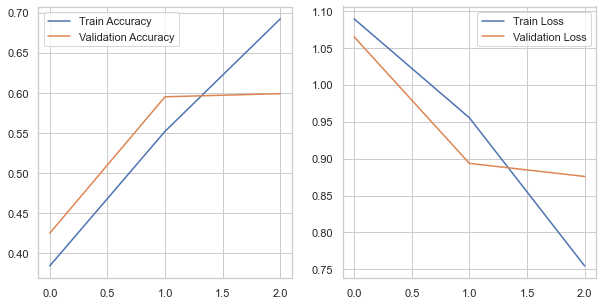

In [64]:
CNN =  make_CNN(dictionary_length,sequence_len)
history = CNN.fit(X_train_NN, pd.get_dummies(y_train),
                     epochs=3, 
                     batch_size=128,
                     validation_data = (X_test_NN ,pd.get_dummies(y_test)),
                     verbose = 0)
me.graph_model_history(history)

Statistics for RNN


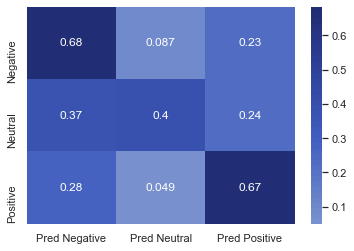

model validation accuracy is: 0.5990799716914367


In [65]:
y_pred = CNN.predict(X_test_NN)
y_pred = np.argmax(y_pred,axis=1)
print('Statistics for RNN')
me.plot_confusion_matrix(y_test,y_pred,
                         #save_path = 'figures/best_CNN_confusion_matrix.png'
                        )
print(f'model validation accuracy is: {accuracy_score(y_test,y_pred)}')

## CNN Evaluation
The model does well classifying positive and negative tweets well, getting 2/3rds correct.  However it struggles to classify neutral tweets.  This is the smallest class.

# RNN Model:
The CNN model looks at windows of words, sequential chunks, but we thought a recurrent model would be able to better understand tweets and draw out their emotional sentiment by reading them like a human, in the order they are written.  Further, like a human, we wanted them to be able to retroactively assign context to words.  Because of this we chose a Bidirectional Long-Short Term Memory, or LSTM model.  These models have memory cells that allow them to carry information about previous words forward in order to understand later words in different ways.  The bidirectionality of this model allowed it to do this front to back and back to front simultaneously.  While the CNN can consider groups of 5 words in a row in a non-linear way, the Bi-LSTM can learn to look at non-sequential groups, 'remembering', for instance, the 1st, 5th, and 10th words and relating those.

We present here our best RNN model, but it was not the only we tried.  Please refer to josh_LSTM_models.ipynb in the notebooks/exploratory folder to see more models.  These include models with pre-trained embedding layers, deeper models with more neurons, and models tuned with the Keras Tuner package from Tensorflow.  None of these performed as well as the relatively simple model we present below.

### The LSTM RNN Model
Below, we create the model itself.  It starts with an embedding layer.  This layer is perhaps the most crucial as it embeds each tokenized word into a high dimensional space.  Each dimension of this space represents a relationship between words.  "Ear" and "sound" might differ along the same dimension as "eye" and "image".  How the model actually embeds the words is learned by the model itself by looking at how words relate in the text, in this case the 22000 or so tweet we gave it to learn from.

The next layer reads the tweets and refers to the values in the embedding layer to make sense of them.  The LSTM layer has a memory, so it can change its understanding of a word based on the words it has read previously.  The bidirectional wrapper for this layer allows it to do this with the tweet both forward and backward.  A given word produces an output based on both the words that come after it, and the words that come before it.  This is similar to how a human makes sense of a text it reads, retroactively contextualizing previously read passages.

The dense layer allows the model to abstract what it learns to some degree before selecting a prediction to output.

In [71]:
def make_RNN(dictionary_length,sequence_len):
    embedding_size = 64
    model = Sequential()
    model.add(Embedding(dictionary_length, sequence_len))
    model.add(Bidirectional(LSTM(units=5, 
                                 return_sequences=True, 
                                 dropout=0.2,
                                 recurrent_regularizer = regularizers.l1_l2(l1=1e-2,l2=1e-2))))
    model.add(GlobalMaxPool1D())
    model.add(Dense(5, activation='relu',
              kernel_regularizer = regularizers.l1_l2(l1=1e-3,l2=1e-3)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer='rmsprop', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])

    return model

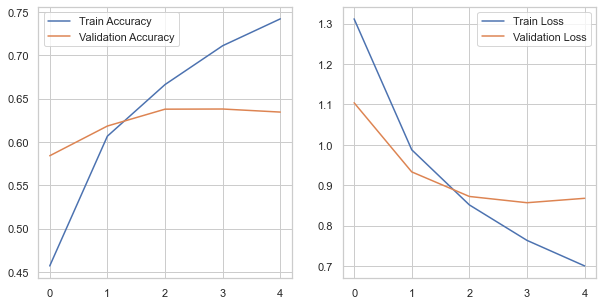

In [72]:
RNN =  make_RNN(dictionary_length,sequence_len)
history = RNN.fit(X_train_NN, y_train,
                     epochs = 5,
                     batch_size = 100,
                     validation_data = (X_test_NN,y_test),
                     verbose = 0)
me.graph_model_history(history)

Statistics for RNN


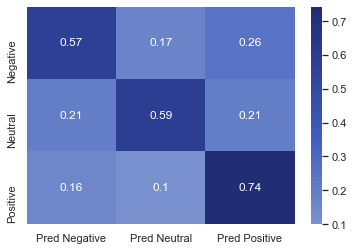

model validation accuracy is: 0.6344656758669498


In [74]:
y_pred = RNN.predict(X_test_NN)
y_pred = np.argmax(y_pred,axis=1)
print('Statistics for RNN')
me.plot_confusion_matrix(y_test,y_pred,
                         #save_path = 'figures/best_LSTM_confusion_matrix.png'
                        )
print(f'model validation accuracy is: {accuracy_score(y_test,y_pred)}')

### RNN Evaluation
This model successfully classifies tweets about 64% of the time, which is okay, but not great.  Random chance would classify tweets correctly 33% of the time, it is definitely better than that.  It does seem to be better at detecting positive tweets, but scores reasonably evenly across categories without terrible bias, which is good.  With this, we turn to another model architecture.

# Shallow modeling
We tried many shallow models, Random Forests, Gaussian Naive Bayes, and Logistic Regression.  However, the Logistic Regression out performed them all.

# Best Model: Logistic Regression
This model takes another approach to predicting sentiments in tweets.  It will run a count vectorized series of processed tweets through a logitic regression algorithm.  The algorithm will find a best fit line through the data that separates each class using a sigmoid function.

### Preparing the data for the logistic regression model
This model will use a Count Vectorizer to prepare the data for the model, rather than an embedding layer.  This makes a vector of all of the unique words in the entire text, much like the vectorizer we used for the data going into the neural networks.  It encodes tweet with a number for each of the words in the vocabulary.  Most variables will be 0, but the numbers can be any integer that represents the number of times that word appears in the tweet.

Count Vectorizer hyperparameters that we will tune are:

* n-gram range: (1,1) unigrams (one word), (2,2) bigrams (two adjacent words), (3,3) trigrams (three adjacent words) and their combinations (1,2) and (2,3).
* maximum document frequency set to 1%, 5% and 25% that means it will ignore temrs that appear in more than given percentage of the documents.
* minimum document frequency set to 1 and 2 that means it will ignore temrs that appear in less than given number of the documents.

In [77]:
cv = CountVectorizer(ngram_range = (1,2))

X_train_vec = cv.fit_transform(X_train)
X_test_vec = cv.transform(X_test)

### Create and fit the Logistic Regression Model

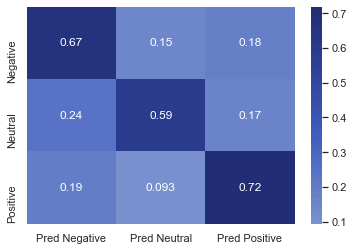

0.6640127388535032

In [82]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_vec, y_train)
y_pred_lg = lr.predict(X_test_vec)
me.plot_confusion_matrix(y_test,y_pred_lg, 
                      #save_path='/figures/logreg_cfm.png'
                     )
accuracy_score(y_test, y_pred_lg)

## Logistic Regression Evaluation
This simple model, one of the simplest kinds of predictive modeling has out performed all of our complicated neural networks.  It also fits and predicts much more quickly.  This is clearly the best model we have come up with in every way, though it still struggle a little predicting neutral tweets.  

# Summary:
We tried embedding our tweet vocabulary in high dimensional space and sending them through a convolutional neural network and a recurrent neural network.  We tried different vectorizing strategies and shallow models and the humble logistic regression model beat them all. This goes to show that natural language processing is more about how you prepare the data then how you process it.  Our model can successfully predict the sentiments of 66% of tweets regarding a specified product, and that's pretty good.  Emotions are hard and labeling emotions is subjective for human labelers.  We are proud of how our model performs and believe that it would be of value to users.